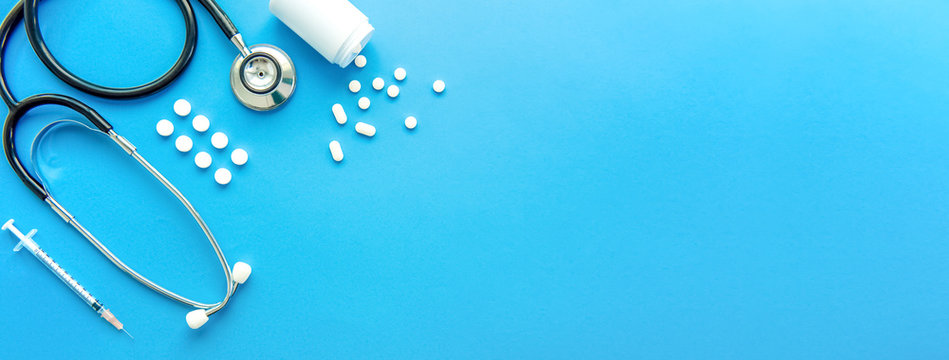

# Stroke Diagnostic Modeling

**Authors:** Anita Camlic, Eddie Juarez, Dermot O'Brien
***

## Overview

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

## Business Problem

Hospitals are constantly looking for new ways to detect health risks in their patients before they occur. We have been asked by Mount Sinai's Diagnostic team to create a model that can predict the likelihood of a stroke in their patients with the use of patient data. The model will flag patients who are at risk of a stroke and will give their general practitioners the opporutnity to work with them on health plans to prevent them from occuring. The model will act as a preliminary diagnosic tool available for all doctors, allowing them to better serve their patients. We will also highlgiht the features of the model that contribute the the most to the models predictions

## Data Overview

### Data Dictionary

- `id`: unique identifier
- `gender`: "Male", "Female" or "Other"
- `sex`: Sex
- `age`: age of the patient
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- `ever_married`: "No" or "Yes"
- `work_type`: children", "Govt_job", "Never_worked", "Private" or "Self-employed"
- ` Residence_type`: "Rural" or "Urban"
- `avg_glucose_level`: average glucose level in blood
- `bmi`: body mass index
- `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"
- `stroke`: 1 if the patient had a stroke or 0 if not

**Note:** "Unknown" in smoking_status means that the information is unavailable for this patient

## Data Understanding

In this section, we are going to explore the dataset with summary statistics and then take a deeper dive into the variables with some visualizations. We are expecting to find some missing values and mislabeled data that we can clean later on.

### Import Data and Create Dataframes

In [1]:
# Import Standard Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score as rere, accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from xgboost import plot_importance
%matplotlib inline

In [2]:
# Import the data
df = pd.read_csv('./Data/stroke.csv')

### Exploratory Data Analysis (EDA)

In [3]:
# Check rows and columns
df.shape

(5110, 12)

In [4]:
# See what each row looks like
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# Check descriptive statistics of numeric columns
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
# Check BMI data
df.bmi.sort_values(ascending=False).head(30)

2128    97.6
4209    92.0
928     78.0
544     71.9
1559    66.8
358     64.8
4188    64.4
2764    63.3
3825    61.6
2840    61.2
270     60.9
4838    60.9
466     60.2
3588    59.7
3060    58.1
4351    57.9
1898    57.7
715     57.5
1595    57.3
4475    57.2
4154    57.2
113     56.6
4952    56.6
2081    56.1
1660    56.0
1584    55.9
4225    55.9
4407    55.7
672     55.7
662     55.7
Name: bmi, dtype: float64

The NIH BMI table max's out at 54, so we are probably going to drop values above that.

In [7]:
# Check for NaN's
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Will need to drop or impute these null values, will probably use knn imputer.

In [8]:
# Check the value counts of the stroke column
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [9]:
# Check the percentage distribution of the stroke column
df.stroke.value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Very imbalanced class data. We will need to use class_weight() parameters and/or SMOTE to address this.

In [10]:
# Check gender value counts
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Likely drop `Other` column from gender do to insufficient data

In [11]:
# Check the stroke rates of males and females
df[['gender', 'stroke']].groupby('gender', as_index=False).mean().sort_values(by='stroke', ascending=False)

,gender,stroke
1,Male,0.051064
0,Female,0.047094
2,Other,0.000000


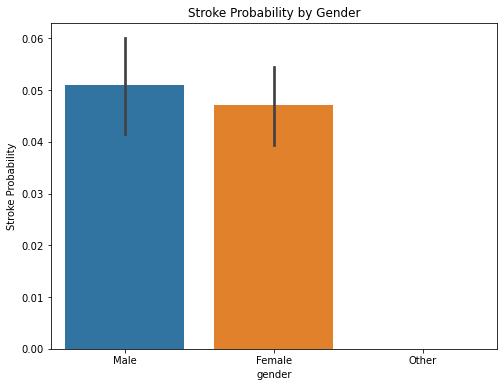

In [12]:
# Create a barplot showing the Stroke Probabilities of males and females
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='gender', y='stroke', data=df)
ax.set_ylabel('Stroke Probability')
ax.set_title('Stroke Probability by Gender');

In [13]:
# Check age for stroke victims
df.loc[df['stroke'] == True]['age'].sort_values()

162     1.32
245    14.00
182    32.00
118    38.00
133    38.00
       ...  
42     82.00
56     82.00
188    82.00
23     82.00
35     82.00
Name: age, Length: 249, dtype: float64

In [14]:
# Check BMI
df.loc[df['bmi'].isnull()]['stroke'].value_counts(normalize=True) 

0    0.800995
1    0.199005
Name: stroke, dtype: float64

This tells us that its important to keep the null values since it somehow contributes to people having a stroke or not.

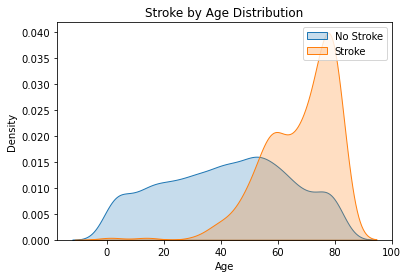

In [15]:
# Create a KDE Plot that shows the Stroke rate of patiens by Age distribution
sns.kdeplot(df['age'][df['stroke'] == 0], label='No Stroke', fill=True)
sns.kdeplot(df['age'][df['stroke'] == 1], label='Stroke', fill=True)
plt.rcParams["figure.figsize"] = (10,8)
plt.xlabel('Age')
plt.title('Stroke by Age Distribution')
plt.legend();

In [16]:
df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Children isnt a `work_type`, so we will probably change children values with Never_worked

In [17]:
df.loc[((df['smoking_status'] == 'Unknown') & (df['age'] <= 12))]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
282,33759,Female,3.00,0,0,No,children,Urban,73.74,16.0,Unknown,0
291,11014,Male,4.00,0,0,No,children,Rural,79.17,20.0,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5078,27446,Female,8.00,0,0,No,children,Urban,76.31,15.5,Unknown,0
5079,42709,Male,1.72,0,0,No,children,Urban,77.28,17.1,Unknown,0
5089,56714,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0
5095,68598,Male,1.08,0,0,No,children,Rural,79.15,17.4,Unknown,0


We can assume that children <=12 do not smoke, so we can change their Unknown status to never worked

## Data Preparation

Based on our EDA, we are going to make some changes to the dataset in hopes to return more accurate metrics from our models. See preparations below:

In [18]:
# Drop row with gender = 'other'
df = df[df.gender != 'Other']

In [19]:
# Drop ID column
df.drop(labels='id', axis=1, inplace=True)

In [20]:
# Put all children work type into never worked
df['work_type'] = df['work_type'].replace(['children'], 'Never_worked')

In [21]:
# If observation is under teenage age (12) and smoking status unknown, change smoking status to never smoked
df.loc[((df['smoking_status'] == 'Unknown') & (df['age'] <= 12)),'smoking_status'] = 'never smoked'

In [22]:
# Drop all observations with bmi greater than 54 because the NIH table limit is 54
df = df.loc[((df['bmi'] <= 54) | (df['bmi'].isna()))]

## Data Modeling
Our approach to modeling will be an iterative one, starting with the most basic model that predicts our majority class, working our way up to exploring different classification models, doing  grid searches on potential winners, compensating for class imbalance with SMOTE, and combining all these techniques using pipelines and continued hyperparameter tuning to display our final model that looks to maximimize othe recall score. We've decided to evaluate our models on recall given the importance of limiting false negatives in this scenario. It is way worse to tell someone they won't have a stroke when they actually will, compared to telling someone they will have a stroke and they don't. For that reason, recall is the best measure of a successful model.

### Class Setup for Model Evaluation

In [23]:
# Create a Class to evaluate each model with cross validation
# This plot was taken from flatiron school's curriculum team and adapted by our team to fit our needs

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_accuracy = None
        self.cv_precision = None
        self.cv_recall = None

        # cross validate immediately when an object is created or not
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_accuracy = cross_val_score(self.model, cv_X, cv_y, cv=kfolds).mean()
        self.cv_recall = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='recall').mean()
        self.cv_precision = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='precision').mean()

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_accuracy: .5f} accuracy
            {self.cv_recall: .5f} recall
            {self.cv_precision: .5f} precision
        ''')
        print(cv_summary)

        return ax

### Dummy Model

In [24]:
# Create variables and split data into training and testing
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
# Dummy Model that predicts all observations to be in the class with the most frequent values (0 - No Stroke)
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [26]:
# Evaluate model with CV
dummy_results = ModelWithCV(model=dummy_model,
                         model_name='dummy_results',
                         X=X_train,
                         y=y_train)

dummy_results.print_cv_summary();

CV Results for `dummy_results` model:
             0.95103 accuracy
             0.00000 recall
             0.00000 precision
        


/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For our baseline/dummy model, our results are as follows: accuracy score of ~.95, recall score of 0, and precision score of 0. This is to be expected. However, the scoring metric we are most interested in optimizing is recall. This is because recall is closely related to false negatives. We want to minimize false negatives. In our case, a false negative would mean that our model predicted that a patient would not have a stroke but they actually did. This would be very bad for our patients and the doctors using this model. However recall and precision are inversely related. So, when we optimize recall, our precision is inversely affected and usually drops to a very low value. The precision score is correlated with false positives. A false positive in our case would mean that our model predicted that a patient will have a stroke, but they actually did not. This is an error we are willing to accept. We would rather our model have more false positives than false negatives. That is why we are choosing recall as our metric, and aiming to get that score as close to 1 as possible.

### Pipeline Setup

In [27]:
# Create pipelines for missing indicator, numeric and categorical to fit into Categorical Transformer.
knn_imp_pipeline = Pipeline(steps=[('knn_imp', KNNImputer(add_indicator=True))])
num_pipeline = Pipeline(steps=[ ('ss', StandardScaler())])
cat_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

We will be scaling our numeric data to combat regularization, or the penalization of our model on large coefficients.

In [28]:
# The "remainder='passthrough'" bit tells the compiler to leave the other df columns unchanged.
CT = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, ['age', 'avg_glucose_level', 'bmi']),
                                         ('cat_pipeline', cat_pipeline, ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])],
                           remainder='passthrough')

Creating this pipeline will allow us to make changes in a more efficient manner, simplifying the process of itereating models and tuning individual pipelines as needed.

### Logistic Regression

In [29]:
# Create a logistic regression model using created pipeline
logreg_pipe = Pipeline(steps=[('ct', CT),
                              ('knn_imp',knn_imp_pipeline),
                            ('logreg', LogisticRegression())])
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_typ

In [30]:
# Evaluate model with CV
logreg_results = ModelWithCV(model=logreg_pipe,
                         model_name='logreg_pipe',
                         X=X_train,
                         y=y_train)

logreg_results.print_cv_summary();

CV Results for `logreg_pipe` model:
             0.94997 accuracy
             0.02134 recall
             0.40000 precision
        


Above, we ran a logistic regression model with default parameters to see evaluate the algorithm against other ones. As you can see above, our recall score has increased from the dummy/baseline model, but not by much. That number is unacceptable and we will try to see if any of the following models get a higher score than this.

### Decision Trees

In [31]:
# Create a decision tree model using created pipeline
dtree_pipe = Pipeline(steps=[('ct', CT),
                             ('knn_imp',knn_imp_pipeline),
                            ('decisiontree', DecisionTreeClassifier())])
dtree_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_typ

In [32]:
# Evaluate model with CV
dtree_results = ModelWithCV(model=dtree_pipe,
                         model_name='dtree_pipe',
                         X=X_train,
                         y=y_train)

dtree_results.print_cv_summary();

CV Results for `dtree_pipe` model:
             0.90679 accuracy
             0.16117 recall
             0.14936 precision
        


Above, we ran a decision tree model with default parameters to see evaluate the algorithm against other ones. As you can see above, our recall score has increased from the logistic regression model, but not by much.  That number is still unacceptable and we will try to see if any of the following models get a higher score than this.

### KNN

In [33]:
# Create a knn model using created pipeline
knn_pipe = Pipeline(steps=[('ct', CT),
                           ('knn_imp',knn_imp_pipeline),
                            ('knn', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_typ

In [34]:
# Evaluate model with CV
knn_results = ModelWithCV(model=knn_pipe,
                         model_name='knn_pipe',
                         X=X_train,
                         y=y_train)

knn_results.print_cv_summary();

CV Results for `knn_pipe` model:
             0.94866 accuracy
             0.01622 recall
             0.20667 precision
        


Above, we ran a KNN model with default parameters to see evaluate the algorithm against other ones. As you can see above, our recall score has decreased a lot from the decision tree model. That number is still unacceptable and we will try to see if any of the following models get a higher score than this. KNN is very computationally expensive as a model. All of the training data needs to be saved and compared to each individual test datapoint. Not only is the recall score lower than the other models, it also takes a lot more power to run. We will probably not choose this model to proceed with.

### Random Forest

In [35]:
# Create a Random Forest model using created pipeline
rfc_pipe = Pipeline(steps=[('ct', CT),
                           ('knn_imp',knn_imp_pipeline),
                            ('rfc', RandomForestClassifier())])
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_typ

In [36]:
# Evaluate model with CV
rfc_results = ModelWithCV(model=rfc_pipe,
                         model_name='rfc_pipe',
                         X=X_train,
                         y=y_train)

rfc_results.print_cv_summary();

CV Results for `rfc_pipe` model:
             0.94918 accuracy
             0.02148 recall
             0.15000 precision
        


Above, we ran a Random Forest model with default parameters to see evaluate the algorithm against other ones. As you can see above, our recall score has increased since the KNN model. That number is still unacceptable and we will try to see if any of the following models get a higher score than this. 

### Gradient Boost

In [37]:
# Create a Gradient Boost model using created pipeline
gb_pipe = Pipeline(steps=[('ct', CT),
                          ('knn_imp',knn_imp_pipeline),
                            ('gb', GradientBoostingClassifier())])
gb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_typ

In [38]:
# Evaluate model with CV
gb_results = ModelWithCV(model=gb_pipe,
                         model_name='gb_pipe',
                         X=X_train,
                         y=y_train)

gb_results.print_cv_summary();

CV Results for `gb_pipe` model:
             0.95050 accuracy
             0.05932 recall
             0.46714 precision
        


Above, we ran a Gradient Boost model with default hyperparameters and parameters to see evaluate the algorithm against other ones. As you can see above, our recall score has increased since the Random Forest model. That number is still unacceptable and we will try to see if any of the following models get a higher score than this.

It looks as though the models with the highest accuracy are logistic regression(0.95197 accuracy) and Random Forests(0.95197 accuracy). However, the model with the highest recall is Decision Trees( 0.16111 recall).

## Grid Search

#### Random Forest Grid Search #1

In [ ]:
# Random Forest Grid Search 
rf_grid = {'rfc__max_depth': [3,5,7],
 'rfc__max_features': ['auto', 'sqrt',None],
 'rfc__min_samples_leaf': [1, 2, 3],
 'rfc__min_samples_split': [2, 5, 10],
 'rfc__n_estimators': [10,100,200,500]}


In [ ]:
rf_gs = GridSearchCV(estimator=rfc_pipe, param_grid=rf_grid, cv=5, scoring='recall')

In [ ]:
rf_gs.fit(X_train,y_train)

In [ ]:
rf_gs.best_params_

In [ ]:
rf_gs.best_score_

In the above grid search we found that the best max_depth hyperparameter was 7. Since this was on the end of the values we tried, we will do another grid search where 7 is the lowest value. We found that the best hyperparameter for max_features was square root, so we will stick with that for the next iteration of our grid search. The best value for our min samples leaf hyperparameter was 1, and we can't go any lower than that, so we will keep that as our value for the next iteration of grid search. We found 2 to be the best value for our min samples split hyperparameter. 2 is the lowest value this hyperparamater can be so we will keep that for our next iteration. We got 10 for our n_estimators hyperparameter, so we will try lower values for the next iteration.

#### Random Forest Grid Search #2

In [ ]:
rf_grid1 = {'rfc__max_depth': [7,9,11],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1],
 'rfc__min_samples_split': [2],
 'rfc__n_estimators': [5,7,10]}

rf_gs1 = GridSearchCV(estimator=rfc_pipe, param_grid=rf_grid1, cv=5, scoring='recall',verbose=3)

In [ ]:
rf_gs1.fit(X_train,y_train)

In [ ]:
rf_gs1.best_params_

In [ ]:
rf_gs1.best_score_

In the above grid search we found that the best max_depth hyperparameter was 11. Since this was on the end of the values we tried, we will do another grid search where 11 is the lowest value. We found that the best hyperparameter for max_features was square root, so we will stick with that for the next iteration of our grid search. We are going to add a hyperparameter called class weight which will weight our different classes differently. Our dataset is very unbalanced and this will help with that.

In [ ]:
rf_grid2 = {'rfc__max_depth': [11,13,15,17],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1,2,3],
 'rfc__min_samples_split': [2,5,10],
 'rfc__n_estimators': [50,100,150,200],
 'rfc__class_weight': ['balanced','balanced_subsample']}

rf_gs2 = GridSearchCV(estimator=rfc_pipe, param_grid=rf_grid2, cv=5, scoring='recall',verbose=3)

In [ ]:
rf_gs2.fit(X_train,y_train)

In [ ]:
rf_gs2.best_params_

In [ ]:
rf_gs2.best_score_

We found the optimal values, however our recall score is still not where we want it, so we will add SMOTE to our pipelines. SMOTE is used to balance the training dataset with synthetic data. This will hopefully help balance the dataset while also increasing our recall score.

### SMOTE

#### Random Forest Grid Search #3 with SMOTE

In [39]:
imb_pipe = ImPipeline(steps=[('ct', CT),
                             ('knn_imp', KNNImputer(add_indicator=True)),
                             ('sm', SMOTE()),
                            ('rfc', RandomForestClassifier())])

In [40]:
imb_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_typ

In [41]:
imb_results = ModelWithCV(model=imb_pipe,
                         model_name='imb_pipe',
                         X=X_train,
                         y=y_train)

imb_results.print_cv_summary();

CV Results for `imb_pipe` model:
             0.93312 accuracy
             0.10725 recall
             0.18943 precision
        


In [42]:
imb_grid = {'rfc__max_depth': [11,13,15,17],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1,2,3],
 'rfc__min_samples_split': [2,5,10],
 'rfc__n_estimators': [50,100,150,200],
 'rfc__class_weight': ['balanced','balanced_subsample'],
 'sm__k_neighbors': [3, 5, 9]}

imb_gs = GridSearchCV(estimator=imb_pipe, param_grid=imb_grid, cv=5, scoring='recall',verbose=3,n_jobs=-2)

In [43]:
imb_gs.fit(X_train,y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-2)]: Done 266 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-2)]: Done 490 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 778 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 1130 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 1546 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done 2026 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-2)]: Done 2570 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-2)]: Done 3178 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-2)]: Done 3850 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-2)]: Done 4320 out of 4320 | elapsed: 10.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_

In [46]:
imb_gs.best_params_

{'rfc__class_weight': 'balanced',
 'rfc__max_depth': 11,
 'rfc__max_features': 'sqrt',
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 10,
 'rfc__n_estimators': 100,
 'sm__k_neighbors': 3}

In [47]:
imb_gs.best_score_

0.32816500711237556

Here, we use SMOTE with Random Forests to try and change the scores of our model. Unfortunately it didn't get our score as high as we want it, so we will try XGBoost. XGBoost is great for unbalanced datasets.

#### XGBoost

Below we will be running 3 Grid Searces for XGBoost. The hyperparameters we will be tuning within SMOTE are k_neighbors which specifies the number of points surrounding a datapoint to look at when creating new synthetic observations. We will be tuning sampling strategy which is the amount of the majority class we want to match in synthetic data.

For XGBoost, the hyperparameters we are tuning are max_depth, learning_rate, gamma, reg_lambda and scale_pos_weight. Max depth is the maximum depth the trees in the random forest can have. The learning rate controls the rate at which the model learns.Gamma is a regularization parameter. Lambda represents L2 regularization on leaf weights. Scale_pos_weights is a weighting parameter that will help with unbalanced datasets.

##### Round 1

In [51]:
xgb_pipe = ImPipeline(steps=[('ct', CT),
                             ('knn_imp', KNNImputer(add_indicator=True)),
                             ('sm', SMOTE()),
                            ('xgb', xgb.XGBClassifier(objective='binary:logistic', missing=None))])

In [ ]:
xgb_param_grid_1 = {'sm__k_neighbors': [3, 5, 9],
                  'sm__sampling_strategy': ['auto', .7, .8, .9],
                  'xgb__max_depth' : [3,4,5],
                  'xgb__learning_rate': [.1,.01,.05],
                  'xgb__gamma' : [0,.25,1], #encourages pruning
                  'xgb__reg_lambda': [0,1,10], #regularization param
                  'xgb__scale_pos_weight': [1,3,5]} #penalty on choosing incorrect class

In [ ]:
xgb_gs_1 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_1, 
                      cv=5,
                      scoring='recall',
                      verbose=3,
                      n_jobs=-2)

In [ ]:
xgb_gs_1.fit(X_train,y_train)

In [ ]:
xgb_gs_1.best_params_

In [ ]:
xgb_gs_1.best_score_

In [ ]:
best_xgb_1 = xgb_gs_1.best_estimator_

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(best_xgb_1, X_train, y_train, values_format='d', display_labels=['Stroke','No Stroke']);

In [ ]:
# Evaluate model with CV
best_xgb_results_1 = ModelWithCV(model=best_xgb,
                         model_name='best_xgb',
                         X=X_train,
                         y=y_train)

In [ ]:
best_xgb_results.print_cv_summary();

XGBoost has significantly shot up our recall score to ~.94, very close to 1. We will continue iterating to see if it can increase, but we are already on a much better track than previously with other models.

##### Round 2

In [ ]:
xgb_param_grid_2 = {'sm__k_neighbors': [9, 11, 13],
                    'sm__sampling_strategy': [.8],
                    'xgb__max_depth' : [1, 2, 3],
                    'xgb__learning_rate': [.01],
                    'xgb__gamma' : [.25],
                    'xgb__reg_lambda': [10, 15, 20], 
                    'xgb__scale_pos_weight': [5, 7, 9]} 

In [ ]:
xgb_gs_2 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_2, 
                      cv=5,
                      scoring='recall',
                      verbose=3,
                      n_jobs=-2)

In [ ]:
xgb_gs_2.fit(X_train,y_train)

In [ ]:
xgb_gs_2.best_params_

In [ ]:
xgb_gs_2.best_score_

In [ ]:
best_xgb_2 = xgb_gs_2.best_estimator_

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(best_xgb_2, X_train, y_train, values_format='d', display_labels=['Stroke','No Stroke']);

In [ ]:
# Evaluate model with CV
best_xgb_results_2 = ModelWithCV(model=best_xgb_2,
                         model_name='best_xgb_2',
                         X=X_train,
                         y=y_train)

In [ ]:
best_xgb_results_2.print_cv_summary();

For this next model, we explored deeper into a few variables that, in our previous model, returned the tails of value in the grid search. These are k_neighbors, max_depth, reg_lambda, and scale_pos_weight. A few hyperparameters gave us our middle values, so we will leave those as is. The results are a bit underwhelming, decreasing our recall by ~.02. Let's keep tuning to see what we can come up with.

##### Round 3

In [52]:
xgb_param_grid_3 = {'sm__k_neighbors': [9],
                    'sm__sampling_strategy': [.8],
                    'xgb__max_depth' : [1],
                    'xgb__learning_rate': [.01],
                    'xgb__gamma' : [.25],
                    'xgb__reg_lambda': [10], 
                    'xgb__scale_pos_weight': [7],
                    'xgb__n_estimators': [100, 200, 300],
                    'xgb__colsample_bytree': [.3, .5, .7]} 

In [53]:
xgb_gs_3 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_3, 
                      cv=5,
                      scoring='recall',
                      verbose=3,
                      n_jobs=-2)

In [54]:
xgb_gs_3.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  40 out of  45 | elapsed:    2.6s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed:    2.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_

In [55]:
xgb_gs_3.best_params_

{'sm__k_neighbors': 9,
 'sm__sampling_strategy': 0.8,
 'xgb__colsample_bytree': 0.3,
 'xgb__gamma': 0.25,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 1,
 'xgb__n_estimators': 100,
 'xgb__reg_lambda': 10,
 'xgb__scale_pos_weight': 7}

In [56]:
xgb_gs_3.best_score_

0.9839260312944523

In [57]:
best_xgb_3 = xgb_gs_3.best_estimator_

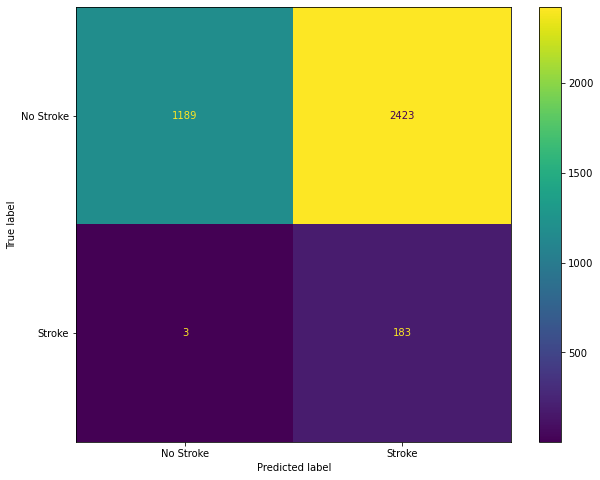

In [58]:
# Plot confusion matrix
plot_confusion_matrix(best_xgb_3, X_train, y_train, values_format='d', display_labels=['No Stroke','Stroke']);

In [59]:
# Evaluate model with CV
best_xgb_results_3 = ModelWithCV(model=best_xgb_3,
                         model_name='best_xgb_3',
                         X=X_train,
                         y=y_train)

In [60]:
best_xgb_results_3.print_cv_summary();

CV Results for `best_xgb_3` model:
             0.35520 accuracy
             0.98393 recall
             0.06681 precision
        


The above model is our final model. Below are the hyperparameters we used. We got up to a recall score of ~.99. There was only one false negatives predicted in this models iteration. With this, we can confidently say that our model will predict well on new unseen data.

k_neighbors: 9


sampling_strategy: 0.8


colsample_bytree: 0.3


gamma: 0.25


learning_rate: 0.01
 
 
max_depth: 1
 
 
n_estimators: 100
 
 
reg_lambda: 10
 
 
scale_pos_weight: 7

### Feature Importance

In this step, we will be looking at which features in our model contribute the most to prediciting whether or not someone is at risk of a stroke.

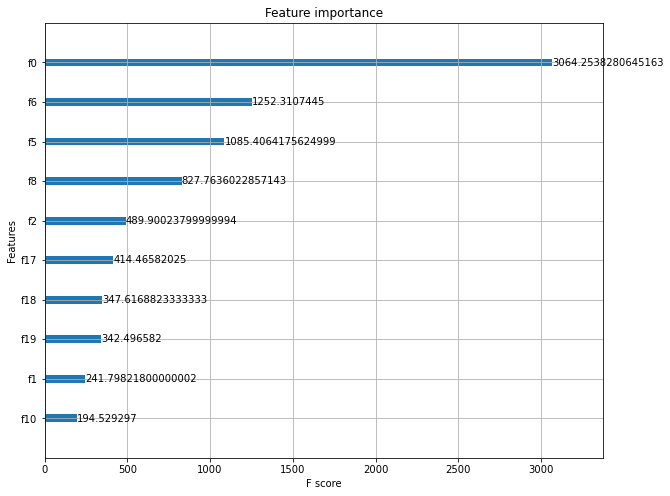

In [61]:
plot_importance(best_xgb_3.steps[3][1], max_num_features=10, importance_type='gain');

This is a test of the plot_importance method, however we are unaware what the names of the features are on the left. We'll manually create our own dataframe to create ease of use for visuals.

In [62]:
trial = CT.fit_transform(X_train)
trial

array([[-1.59245401, -0.93152034, -1.33259501, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.83543446, -1.10519372, -0.59640569, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.43814362, -0.23301718,  0.88960609, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.75372891, -0.36433667, -1.15536424, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00329065, -0.68949807, -0.24194416, ...,  0.        ,
         0.        ,  0.        ],
       [-0.40058149,  0.63176424, -1.12809797, ...,  0.        ,
         0.        ,  0.        ]])

In [63]:
knn_imp_pipeline.fit_transform(trial)

array([[-1.59245401, -0.93152034, -1.33259501, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.83543446, -1.10519372, -0.59640569, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.43814362, -0.23301718,  0.88960609, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.75372891, -0.36433667, -1.15536424, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00329065, -0.68949807, -0.24194416, ...,  0.        ,
         0.        ,  0.        ],
       [-0.40058149,  0.63176424, -1.12809797, ...,  0.        ,
         0.        ,  0.        ]])

In [64]:
feature_names = ['age', 'avg_glucose_level', 'bmi']

In [65]:
ohe_features = list(CT.named_transformers_['cat_pipeline']['ohe'].get_feature_names())

In [66]:
full_features = feature_names + ohe_features

In [67]:
full_features.extend(['hypertension', 'heart_disease', 'bmi_flag'])
full_features

['age',
 'avg_glucose_level',
 'bmi',
 'x0_Female',
 'x0_Male',
 'x1_No',
 'x1_Yes',
 'x2_Govt_job',
 'x2_Never_worked',
 'x2_Private',
 'x2_Self-employed',
 'x3_Rural',
 'x3_Urban',
 'x4_Unknown',
 'x4_formerly smoked',
 'x4_never smoked',
 'x4_smokes',
 'hypertension',
 'heart_disease',
 'bmi_flag']

In [68]:
full_feature_scores = list(best_xgb_3.steps[3][1].feature_importances_)

In [69]:
len(full_features)

20

In [70]:
len(best_xgb_3.steps[3][1].feature_importances_)

20

In [71]:
best_xgb_3.steps[3][1].feature_importances_

array([0.3709507 , 0.02927147, 0.05930607, 0.        , 0.        ,
       0.1313965 , 0.15160152, 0.        , 0.10020693, 0.        ,
       0.02354922, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05017417, 0.04208161, 0.04146176],
      dtype=float32)

In [72]:
tuples_list = list(zip(full_features, full_feature_scores))

In [73]:
important_features = pd.DataFrame(tuples_list, columns = ['Features', 'Importance'])
important_features_sorted = important_features.sort_values(by='Importance', ascending=False).head(10)

In [74]:
important_features_sorted

,Features,Importance
0,age,0.370951
6,x1_Yes,0.151602
5,x1_No,0.131397
8,x2_Never_worked,0.100207
2,bmi,0.059306
17,hypertension,0.050174
18,heart_disease,0.042082
19,bmi_flag,0.041462
1,avg_glucose_level,0.029271
10,x2_Self-employed,0.023549


As you can see above, these are the top 10 most important features to our model. Age is most important to our model and makes sense because the older you get, the more occurances of stroke there are. The next three most important features are married, not married, and never worked. We are not going to look into this because marriage status and job status of never worked are highly correlated with age. Instead, we will look into the next most important feature, and our most important health measurement, BMI. This makes sense because BMI is highly correlated with those who are overweight. More fat tissue is linked to poor blood circulation, and in turn strokes.

#### Run Final Model on Test Data

In [75]:
final_model = best_xgb_3

In [76]:
y_pred_test = final_model.predict(X_test)

In [77]:
rere(y_test, y_pred_test)

1.0

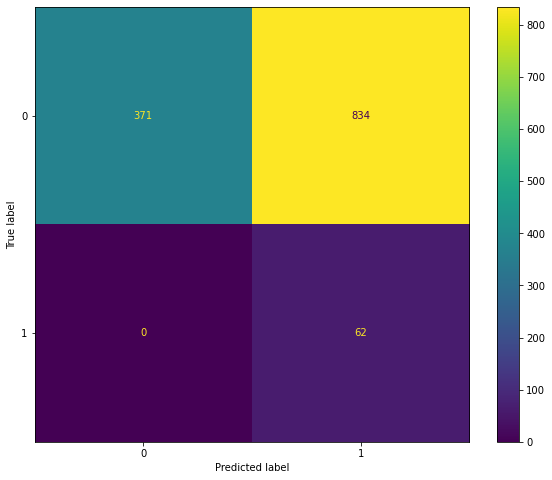

In [78]:
plot_confusion_matrix(final_model, X_test, y_test)

The results change each time we run, but we are getting recall scores between .96 and 1 in every iteration. We can be confident then in our models ability to predict our true class given how well it is performing on unseen data. 

#### Visuals

In [81]:
# Rename columns in feature dataframe for visuals
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['age'], 'Age')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['x1_Yes'], 'Married')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['x1_No'], 'Not Married')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['x2_Never_worked'], 'Never Worked')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['bmi'], 'Bmi')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['bmi_flag'], 'Bmi Flag')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['hypertension'], 'Hypertension')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['avg_glucose_level'], 'Avg Glucose Level')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['heart_disease'], 'Heart Disease')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['x2_Self-employed'], 'Self-Employed')

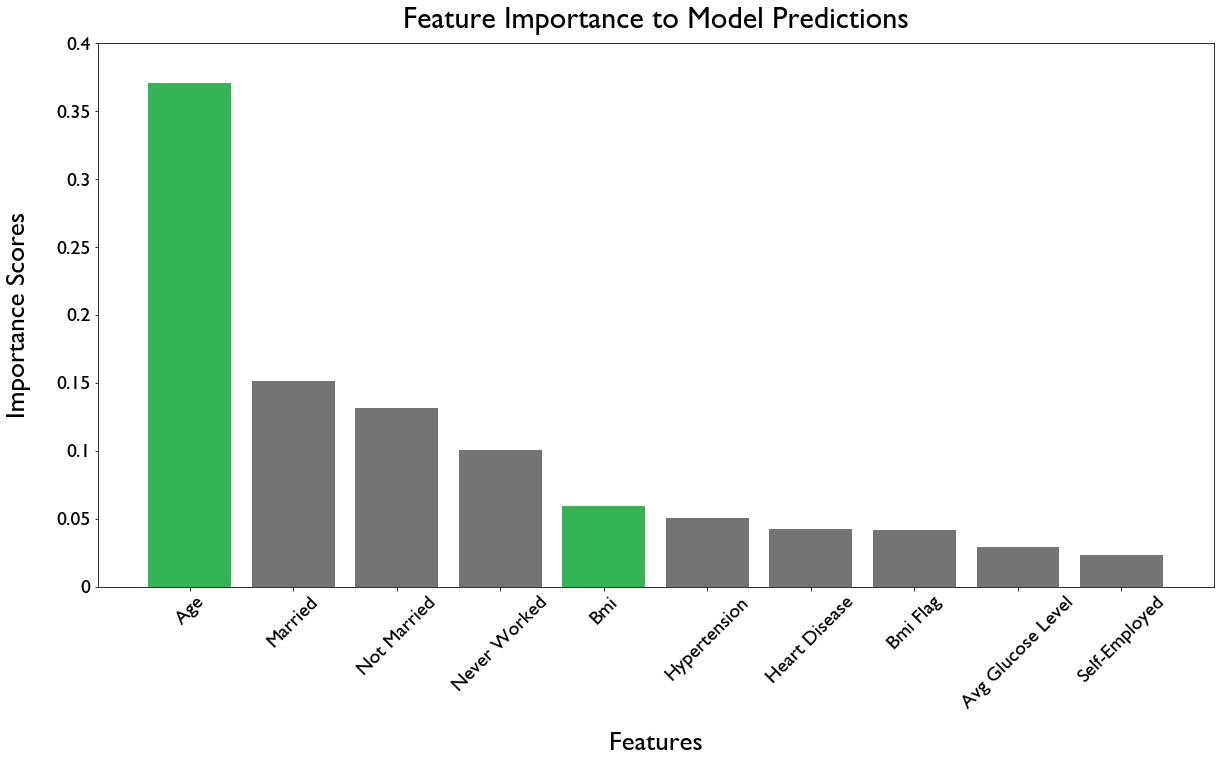

In [82]:
# Visualize Feature Importance

# Create variables for chart
important_features_x = important_features_sorted['Features']
feature_scores_y = important_features_sorted['Importance']
y_ticks = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
c = ['#34b456', '#747474', '#747474', '#747474', '#34b456', '#747474', '#747474', '#747474', '#747474', '#747474']

# Change font family
plt.rcParams.update({'font.family':'Gill Sans'})

# Create bar chart
fig, ax = plt.subplots(figsize = (20,10))

bars = ax.bar(important_features_x, feature_scores_y, color=c)
ax.set_xlabel('Features', fontsize=27, labelpad=20) 
ax.set_ylabel('Importance Scores', fontsize=27, labelpad=25)
ax.set_title('Feature Importance to Model Predictions', fontsize=30, pad=15)
ax.set_ylim(0, 0.40, 0.05)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=20)
ax.set_xticks(important_features_x)
ax.set_xticklabels(important_features_x, fontsize=20, rotation=45);

plt.savefig('./Results/Feature_Importances.jpg', bbox_inches='tight')

We've laid out our top 10 features according to contribution to the models prediction. We will be focusing on age and bmi as our two most important features for doctors to focus on relative to their patients.

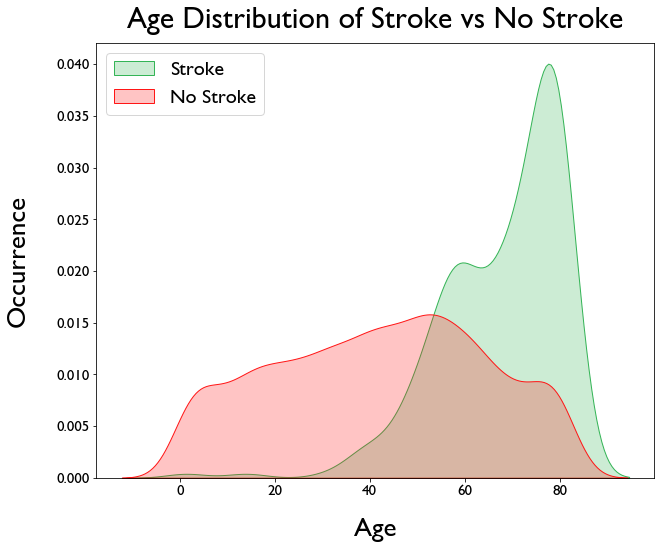

In [83]:
# Create a KDE Plot that shows the distribution of stroke vs not strok by Age
sns.kdeplot(df['age'][df['stroke'] == 1], label='Stroke', color='#34b456', fill=True)
sns.kdeplot(df['age'][df['stroke'] == 0], label='No Stroke', color='#ff1616', fill=True)
plt.rcParams.update({'font.family':'Gill Sans'})
plt.rcParams["figure.figsize"] = (10, 10)
plt.xlabel('Age', fontsize=27, labelpad=20)
plt.ylabel('Occurrence', fontsize=27, labelpad=25)
plt.title('Age Distribution of Stroke vs No Stroke', fontsize=30, pad=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper left", fontsize=20)

plt.savefig('./Results/Age_Distribution.jpg', bbox_inches='tight');

This next graph simply tells us that strokes occur more in people who are older. If we look at the green section, you can see that stroke victims shoot up after age 40. This tell us that there is a strong correlation between age and potential strokes.

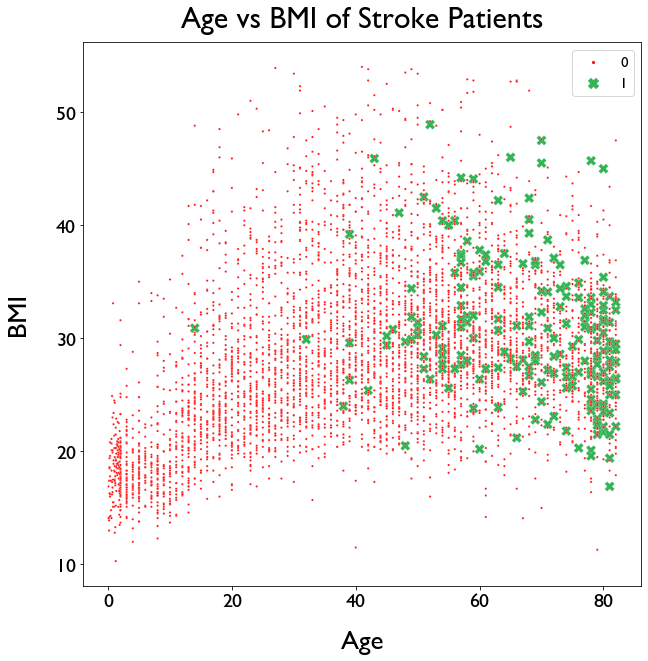

In [84]:
# Create a Scatter Plot showing the Age and BMI's of Stroke Victims
bmi_X = df['age']
bmi_y = df['bmi']
stroke_z = df['stroke']
#ax = 
sns.scatterplot(data=df, x=bmi_X, y=bmi_y, hue=stroke_z, style=stroke_z, palette=['#ff1616','#34b456'], size=stroke_z, sizes={0:5, 1:100})
#sns.scatterplot(ax=ax);
plt.rcParams.update({'font.family':'Gill Sans'})
plt.rcParams["figure.figsize"] = (15, 10)
plt.xlabel('Age', fontsize=27, labelpad=20)
plt.ylabel('BMI', fontsize=27, labelpad=25)
plt.title('Age vs BMI of Stroke Patients', fontsize=30, pad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper right", fontsize=15);

plt.savefig('./Results/BMI_Stroke.jpg', bbox_inches='tight');

Here we've displayed BMI vs Age, but highlighted those who have gotten a stroke as a green X. As you can see, their is a cluster in the top right corner, which indicated that older people and those with higher bmi's tend to have strokes more often. It is interesting as well to see the number of strokes shoot up after a bmi of 25, which is the classifcation of overweight by the CDC and NIH.

## Evaluation

Our model was created to predict potential patients at risk of suffering from a stroke. We chose the metric recall because it is associated with decreasing the amount of false negative values of our model. Our final recall score was 98 percent. This means that our model, when ran on unseen data, predicted true positives correctly 98 percent of the time. Our model fitted our data very well. XGBoost uses the errors to improve itself which is very powerful. Our final model is way better than our baseline model. We are very confident that our model will generalize well on future unseen data. 

This model will benefit the business if put to use because it will flag potential stroke victims, potentially saving thier lives due to early detection and early treament. This model is extremely powerful and can be very beneficial to Mount Sinai's Diagnostic Team. 

## Conclusions

In conclusion, we recommend that Mount Sinai takes our model and  incorporates it as a tool for their doctors in preliminary diagnostics for their patients. Once doctors idenitfy those patients that are at risk of stroke, they can work to build comprehenive health plans in hopes of preventing strokes. The two attributes of a person we think doctors should focus most on are the age of the patient and their bmi levels. Our models have shown that these two features contribute greatly to the prediction of stroke cases. When focusing on patients, they should look to treat those older patients first, as well as those with high bmi's, possibly working to lower their bmi's as well.

One reason our analysis might not fully solve the busines problem is that our dataset is fairly small, so it might not have captured all of the possible cases of potential stroke victim. Another reason our analysis might not fully solve the business problem is because we don't have many features aligned with strokes. If we had more features that were linked to strokes, our model could be improved.

In the future, we would love to further explore health data and create a model that maintains our recall with in more comprehensive unseen data. We also would like to apply similar model techniques to health data to predict other illnesses like heart disease.